# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 20, 17, 33, 32, 334331)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
os.environ["HOPSWORKS_API_KEY"] = "Q1hpGzlHnrKrf4g1.kxP3EPqrvulBl7XQ8oRJE3tFaxhg2PexXjhUN8Wcgvu78uN74Sw8FtH4lZODqe3D"

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160344
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.581654E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
# Access the feature names of the trained XGBoost model
feature_names = retrieved_xgboost_model.get_booster().feature_names

# Print the feature names
print("Feature names:", feature_names)


Feature names: ['past_air_quality', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']


## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
today_timestamp = pd.to_datetime(today)
batch_data = weather_fg.filter(weather_fg.date >= today_timestamp ).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-27 00:00:00+00:00,20.350000,0.0,4.104631,37.875053,lahore
1,2024-11-21 00:00:00+00:00,21.700001,0.0,1.138420,71.564964,lahore
2,2024-11-26 00:00:00+00:00,20.750000,0.0,4.680000,270.000000,lahore
3,2024-11-28 00:00:00+00:00,19.799999,0.0,2.189795,9.462248,lahore
4,2024-11-22 00:00:00+00:00,21.850000,0.0,4.610250,128.659836,lahore
5,2024-11-25 00:00:00+00:00,20.750000,0.0,6.439876,296.564972,lahore
6,2024-11-24 00:00:00+00:00,21.400000,0.0,4.334974,318.366547,lahore
7,2024-11-23 00:00:00+00:00,22.250000,0.0,5.091168,44.999897,lahore


### Get Mean air quality for past days

In [9]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
selected_features = air_quality_fg.select_all() #(['pm25']).join(weather_fg.select_all(), on=['city'])
selected_features = selected_features.read()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.74s) 


In [10]:
selected_features = selected_features.sort_values(by='date').reset_index(drop=True)

In [11]:
past_air_q_list = selected_features[['date', 'pm25']][-3:]['pm25'].tolist()

In [12]:
batch_data = batch_data.sort_values(by='date').reset_index(drop=True)

In [13]:
batch_data['past_air_quality'] = None

In [14]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,past_air_quality
0,2024-11-21 00:00:00+00:00,21.700001,0.0,1.138420,71.564964,lahore,None
1,2024-11-22 00:00:00+00:00,21.850000,0.0,4.610250,128.659836,lahore,None
2,2024-11-23 00:00:00+00:00,22.250000,0.0,5.091168,44.999897,lahore,None
3,2024-11-24 00:00:00+00:00,21.400000,0.0,4.334974,318.366547,lahore,None
4,2024-11-25 00:00:00+00:00,20.750000,0.0,6.439876,296.564972,lahore,None
5,2024-11-26 00:00:00+00:00,20.750000,0.0,4.680000,270.000000,lahore,None
6,2024-11-27 00:00:00+00:00,20.350000,0.0,4.104631,37.875053,lahore,None
7,2024-11-28 00:00:00+00:00,19.799999,0.0,2.189795,9.462248,lahore,None


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [15]:
# Initialize an empty list to store predictions
predictions = []

# Iterate through each row of the DataFrame
for index, row in batch_data.iterrows():
    past_air_quality_mean = sum(past_air_q_list)/3
    # Extract the feature values for prediction as a 1D array
    features = row[['past_air_quality', 'temperature_2m_mean', 'precipitation_sum', 
                    'wind_speed_10m_max', 'wind_direction_10m_dominant']].values
    
    # Reshape features to a 2D array (required by XGBoost's predict method)
    features = features.reshape(1, -1)
    
    # Make a prediction for the row
    prediction = retrieved_xgboost_model.predict(features)
    
    # Append the prediction to the list
    predictions.append(prediction[0])
    past_air_q_list.append(prediction[0])
    past_air_q_list = past_air_q_list[1:]

    # print(past_air_q_list)
    batch_data.loc[index,'past_air_quality'] = past_air_quality_mean

# Add the predictions as a new column in the DataFrame
batch_data['predicted_pm25'] = predictions

# Display the updated DataFrame
batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,past_air_quality,predicted_pm25
0,2024-11-21 00:00:00+00:00,21.700001,0.0,1.138420,71.564964,lahore,35.526667,192.331680
1,2024-11-22 00:00:00+00:00,21.850000,0.0,4.610250,128.659836,lahore,89.443893,193.405090
2,2024-11-23 00:00:00+00:00,22.250000,0.0,5.091168,44.999897,lahore,135.578924,190.043823
3,2024-11-24 00:00:00+00:00,21.400000,0.0,4.334974,318.366547,lahore,191.926865,199.405060
4,2024-11-25 00:00:00+00:00,20.750000,0.0,6.439876,296.564972,lahore,194.284658,189.815140
5,2024-11-26 00:00:00+00:00,20.750000,0.0,4.680000,270.000000,lahore,193.088008,190.914749
6,2024-11-27 00:00:00+00:00,20.350000,0.0,4.104631,37.875053,lahore,193.378316,189.544739
7,2024-11-28 00:00:00+00:00,19.799999,0.0,2.189795,9.462248,lahore,190.091543,201.146835


In [16]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
# batch_data

In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   past_air_quality             8 non-null      object             
 7   predicted_pm25               8 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(2)
memory usage: 480.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [18]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data['date'] = batch_data['date'].dt.tz_convert(None).astype('datetime64[ns]')
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,past_air_quality,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-21,21.700001,0.0,1.138420,71.564964,lahore,35.526667,192.331680,pakistan-lahore-cantonment,pakistan,1
1,2024-11-22,21.850000,0.0,4.610250,128.659836,lahore,89.443893,193.405090,pakistan-lahore-cantonment,pakistan,2
2,2024-11-23,22.250000,0.0,5.091168,44.999897,lahore,135.578924,190.043823,pakistan-lahore-cantonment,pakistan,3
3,2024-11-24,21.400000,0.0,4.334974,318.366547,lahore,191.926865,199.405060,pakistan-lahore-cantonment,pakistan,4
4,2024-11-25,20.750000,0.0,6.439876,296.564972,lahore,194.284658,189.815140,pakistan-lahore-cantonment,pakistan,5
5,2024-11-26,20.750000,0.0,4.680000,270.000000,lahore,193.088008,190.914749,pakistan-lahore-cantonment,pakistan,6
6,2024-11-27,20.350000,0.0,4.104631,37.875053,lahore,193.378316,189.544739,pakistan-lahore-cantonment,pakistan,7
7,2024-11-28,19.799999,0.0,2.189795,9.462248,lahore,190.091543,201.146835,pakistan-lahore-cantonment,pakistan,8


In [19]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         8 non-null      datetime64[ns]
 1   temperature_2m_mean          8 non-null      float32       
 2   precipitation_sum            8 non-null      float32       
 3   wind_speed_10m_max           8 non-null      float32       
 4   wind_direction_10m_dominant  8 non-null      float32       
 5   city                         8 non-null      object        
 6   past_air_quality             8 non-null      object        
 7   predicted_pm25               8 non-null      float32       
 8   street                       8 non-null      object        
 9   country                      8 non-null      object        
 10  days_before_forecast_day     8 non-null      int64         
dtypes: datetime64[ns](1), float32(5), int64(1), objec

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-20 17:33:50,413 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



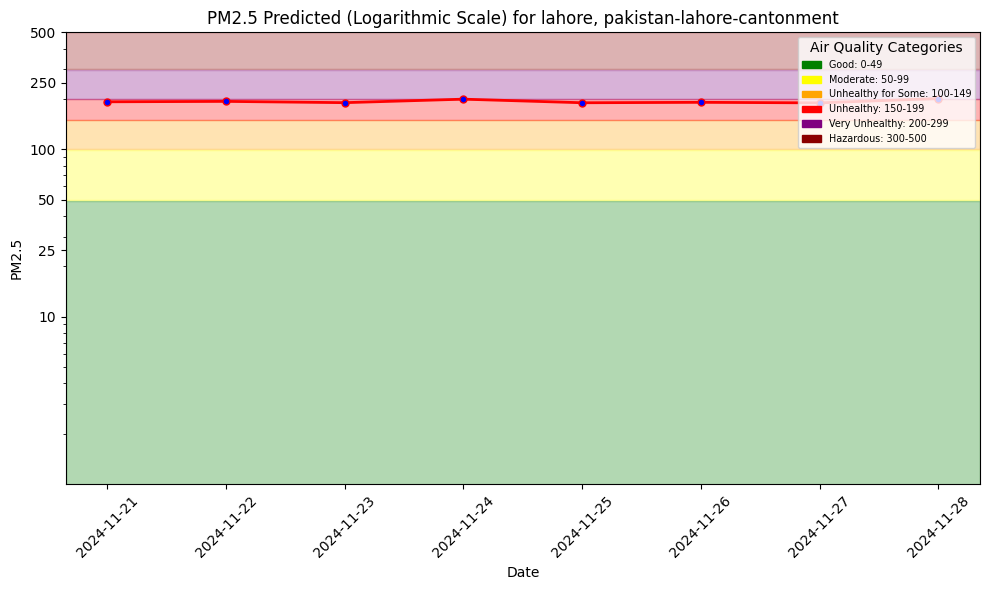

In [20]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [34]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [35]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1160344/fs/1151047/fg/1357153


Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160344/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fd57a750220>, None)

In [36]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,past_air_quality,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,21.700001,0.0,1.13842,71.564964,lahore,35.526667,192.33168,pakistan-lahore-cantonment,pakistan,1


In [37]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.44s) 


,date,pm25,country,city,street,url,past_air_quality
0,2020-06-17,22.120001,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,19.980000
1,2022-09-03,8.350000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,9.383334
2,2024-09-21,16.750000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,13.490000
3,2023-12-12,106.650002,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,90.556667
4,2022-04-30,33.599998,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,19.146666
...,...,...,...,...,...,...,...
1797,2022-01-25,73.930000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,64.386668
1798,2022-02-02,45.869999,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,75.203332
1799,2021-05-31,8.250000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,10.740000
1800,2024-11-19,55.000000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,84.966667


In [38]:
air_quality_df['date']

0       2020-06-17
1       2022-09-03
2       2024-09-21
3       2023-12-12
4       2022-04-30
           ...    
1797    2022-01-25
1798    2022-02-02
1799    2021-05-31
1800    2024-11-19
1801    2024-11-20
Name: date, Length: 1802, dtype: object

In [39]:
monitoring_df['date']

0   2024-11-21 00:00:00+00:00
Name: date, dtype: datetime64[us, UTC]

In [40]:
air_quality_df['date'] = pd.to_datetime(air_quality_df['date'])
monitoring_df['date'] = monitoring_df['date'].dt.tz_convert(None).astype('datetime64[ns]')

In [41]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2023-08-29 00:00:00+00:00,28.823000,3.4,10.966713,252.869614,lahore
1,2020-07-11 00:00:00+00:00,32.341751,6.1,14.264361,137.062943,lahore
2,2021-01-22 00:00:00+00:00,13.041748,0.0,17.072504,116.509308,lahore
3,2020-09-24 00:00:00+00:00,31.358414,0.0,16.610792,278.944000,lahore
4,2020-03-16 00:00:00+00:00,17.618834,0.0,9.085988,295.851776,lahore
...,...,...,...,...,...,...
1811,2024-11-22 00:00:00+00:00,21.850000,0.0,4.610250,128.659836,lahore
1812,2024-11-25 00:00:00+00:00,20.750000,0.0,6.439876,296.564972,lahore
1813,2024-11-24 00:00:00+00:00,21.400000,0.0,4.334974,318.366547,lahore
1814,2024-11-19 00:00:00+00:00,21.299999,0.0,6.618519,292.380188,lahore


In [42]:
air_quality_df

,date,pm25,country,city,street,url,past_air_quality
0,2020-06-17,22.120001,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,19.980000
1,2022-09-03,8.350000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,9.383334
2,2024-09-21,16.750000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,13.490000
3,2023-12-12,106.650002,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,90.556667
4,2022-04-30,33.599998,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,19.146666
...,...,...,...,...,...,...,...
1797,2022-01-25,73.930000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,64.386668
1798,2022-02-02,45.869999,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,75.203332
1799,2021-05-31,8.250000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,10.740000
1800,2024-11-19,55.000000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,84.966667


In [43]:
monitor_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,past_air_quality,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-28 00:00:00+00:00,19.799999,0.0,2.189795,9.462248,lahore,190.091543,201.146835,pakistan-lahore-cantonment,pakistan,8
1,2024-11-24 00:00:00+00:00,21.400000,0.0,4.334974,318.366547,lahore,191.926865,199.405060,pakistan-lahore-cantonment,pakistan,4
2,2024-11-21 00:00:00+00:00,21.700001,0.0,1.138420,71.564964,lahore,35.526667,192.331680,pakistan-lahore-cantonment,pakistan,1
3,2024-11-22 00:00:00+00:00,21.850000,0.0,4.610250,128.659836,lahore,89.443893,193.405090,pakistan-lahore-cantonment,pakistan,2
4,2024-11-27 00:00:00+00:00,20.350000,0.0,4.104631,37.875053,lahore,193.378316,189.544739,pakistan-lahore-cantonment,pakistan,7
5,2024-11-26 00:00:00+00:00,20.750000,0.0,4.680000,270.000000,lahore,193.088008,190.914749,pakistan-lahore-cantonment,pakistan,6
6,2024-11-25 00:00:00+00:00,20.750000,0.0,6.439876,296.564972,lahore,194.284658,189.815140,pakistan-lahore-cantonment,pakistan,5
7,2024-11-23 00:00:00+00:00,22.250000,0.0,5.091168,44.999897,lahore,135.578924,190.043823,pakistan-lahore-cantonment,pakistan,3


In [47]:


outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.99s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 


Uploading Dataframe: 0.00% |          | Rows 0/2 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160344/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,past_air_quality,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2024-11-20,21.299999,0.0,0.36,270.0,lahore,43.710003,62.04525,21.0,Drottninggatan,Sweden,1
1,2024-11-20,21.299999,0.0,0.36,270.0,lahore,43.710003,62.04525,21.0,Drottninggatan,Sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

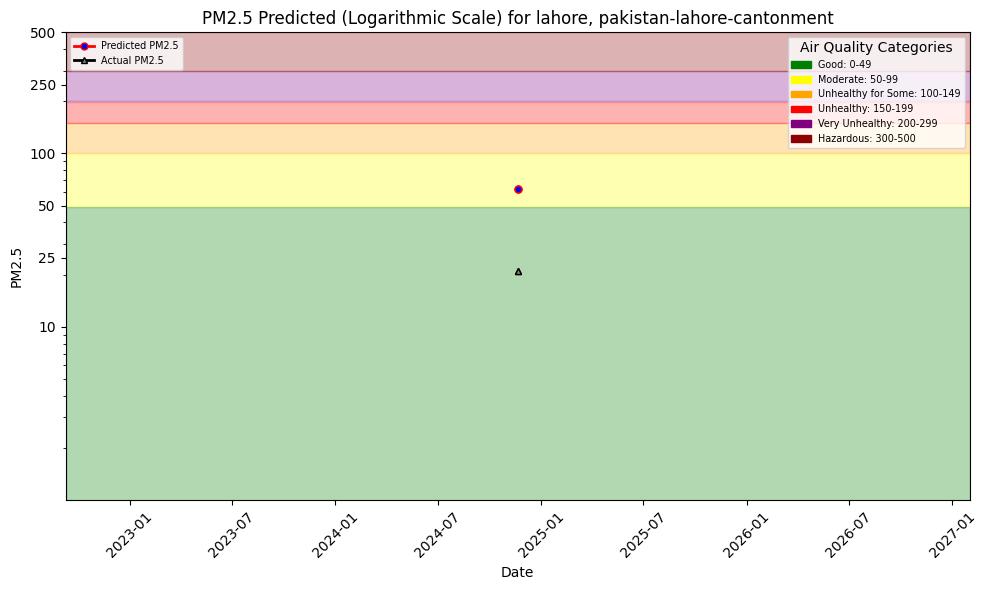

In [48]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

In [135]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [159]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
selected_features = air_quality_fg.select_all(['pm25', 'past_air_quality']).join(weather_fg.select(['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']), on=['city'])
selected_features = selected_features.read()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.94s) 


In [160]:
predicted_data = monitor_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 


In [162]:
selected_features['date'] = pd.to_datetime(selected_features['date'], utc=True).dt.tz_convert(None).astype('datetime64[ns]')

#get predicted pm25
selected_features['predicted_pm25'] = retrieved_xgboost_model.predict(selected_features[['past_air_quality','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])

predicted_data = predicted_data[['date','predicted_pm25']]
predicted_data['date'] = predicted_data['date'].dt.tz_convert(None).astype('datetime64[ns]')

In [163]:
predicted_data = predicted_data.sort_values(by=['date'], ascending=True).reset_index(drop=True)

In [164]:
selected_features

,date,pm25,country,city,street,url,past_air_quality,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25
0,2019-12-09,248.429993,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,42.354327,14.900082,0.2,9.422101,11.842063,247.584579
1,2019-12-10,299.160004,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,42.354327,14.052165,0.0,8.534353,69.443985,295.248169
2,2019-12-11,247.270004,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,264.953334,14.975082,2.3,8.089993,99.649574,246.817215
3,2019-12-12,53.560001,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,199.996670,13.347999,15.8,16.904673,72.617531,53.997143
4,2019-12-13,75.440002,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,125.423336,12.170915,0.0,11.525623,243.006943,77.091026
...,...,...,...,...,...,...,...,...,...,...,...,...
1796,2024-11-15,159.800003,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,164.996668,20.023001,1.6,12.982480,17.241518,139.838104
1797,2024-11-16,178.770004,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,188.106669,18.385500,0.0,6.330782,24.163300,159.749237
1798,2024-11-17,45.549999,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,128.040002,17.897999,0.0,7.040739,297.781921,127.975082
1799,2024-11-18,30.580000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005,84.966668,17.897999,0.0,7.040739,297.781921,97.848595


In [168]:
selected_features = selected_features[['date', 'pm25', 'predicted_pm25']]
# selected_features = selected_features.groupby('date').first().reset_index()
# predicted_data = predicted_data.groupby('date').first().reset_index()
combined_df = pd.merge(selected_features, predicted_data,on='date', how='outer')

In [169]:
predicted_data

,date,predicted_pm25
0,2024-11-19,88.178535
1,2024-11-20,62.045250
2,2024-11-21,192.331680
3,2024-11-22,193.405090
4,2024-11-23,190.043823
5,2024-11-24,199.405060
6,2024-11-25,189.815140
7,2024-11-26,190.914749
8,2024-11-27,189.544739
9,2024-11-28,201.146835


In [170]:
combined_df

,date,pm25,predicted_pm25_x,predicted_pm25_y
0,2019-12-09,248.429993,247.584579,NaN
1,2019-12-10,299.160004,295.248169,NaN
2,2019-12-11,247.270004,246.817215,NaN
3,2019-12-12,53.560001,53.997143,NaN
4,2019-12-13,75.440002,77.091026,NaN
...,...,...,...,...
1805,2024-11-24,NaN,NaN,199.405060
1806,2024-11-25,NaN,NaN,189.815140
1807,2024-11-26,NaN,NaN,190.914749
1808,2024-11-27,NaN,NaN,189.544739


In [171]:
combined_df['date'] =  pd.to_datetime(combined_df['date'], utc=True).dt.tz_convert(None).astype('datetime64[ns]')

In [172]:
# Combine the predicted_pm25_x and predicted_pm25_y columns into one
combined_df['predicted_pm25'] = combined_df['predicted_pm25_x'].combine_first(combined_df['predicted_pm25_y'])

# Drop the individual columns after merging if no longer needed
combined_df = combined_df.drop(columns=['predicted_pm25_x', 'predicted_pm25_y'])


        date        pm25  predicted_pm25
0 2019-12-09  248.429993      247.584579
1 2019-12-10  299.160004      295.248169
2 2019-12-11  247.270004      246.817215
3 2019-12-12   53.560001       53.997143
4 2019-12-13   75.440002       77.091026


In [173]:
combined_df

,date,pm25,predicted_pm25
0,2019-12-09,248.429993,247.584579
1,2019-12-10,299.160004,295.248169
2,2019-12-11,247.270004,246.817215
3,2019-12-12,53.560001,53.997143
4,2019-12-13,75.440002,77.091026
...,...,...,...
1805,2024-11-24,NaN,199.405060
1806,2024-11-25,NaN,189.815140
1807,2024-11-26,NaN,190.914749
1808,2024-11-27,NaN,189.544739


---